# Statistical Analysis of Topological Indices

## Topological Indices
we use the following indices
- wiener index
- randic index
- generalized randic index
- harmonic index
- atom bond connectivity index
- first zagreb index
- second zagreb index

In [ ]:
# we need to read the dataset from the pickle file
import pickle

with open('dataset.pickle', 'rb') as f:
    dataset = pickle.load(f)

for key in dataset.keys():
    print(f"datasetkey: {key}, shape: {len(dataset[key])}")

# order the dataset by number of nodes
for key in dataset.keys():
    dataset[key] = sorted(dataset[key], key=lambda x: x.number_of_nodes())


In [ ]:
# we use grinpy to calculate the topological indices for each graph
import grinpy as gp
import networkx as nx
from tqdm.notebook import tqdm

def get_topological_indices(G):
    ''' Create a dictionary with the topological indices of a graph G.'''
    topological_indices = {}
    topological_indices['nodes'] = nx.number_of_nodes(G)
    topological_indices['wiener_index'] = gp.wiener_index(G)
    topological_indices['randic_index'] = gp.randic_index(G)
    topological_indices['generalized_randic_index'] = gp.generalized_randic_index(G, 2)
    topological_indices['harmonic_index'] = gp.harmonic_index(G)
    topological_indices['atom_bond_connectivity_index'] = gp.atom_bond_connectivity_index(G)
    topological_indices['first_zagreb_index'] = gp.first_zagreb_index(G)
    topological_indices['second_zagreb_index'] = gp.second_zagreb_index(G)

    return topological_indices

def topological_indices_all_graphs(dataSet, subtypes_to_skip = []):
    ''' Create a dictionary with the topological indices of all graphs in the dataset.'''
    topological_indices = {}

    for key in tqdm(dataSet.keys(), total=len(dataset.keys()), desc='Calculating TIs for Class'):

        if key in subtypes_to_skip:
            continue

        topological_indices[key] = {}
        l = len(dataSet[key])
        for (i, graph) in tqdm(enumerate(dataSet[key]), total=l, desc=f'Calculating TIs for {key} graphs'):
            topological_indices[key][graph] = get_topological_indices(graph)
    return topological_indices


subtypes_to_skip = []

topological_indices_all_graphs = topological_indices_all_graphs(dataset, subtypes_to_skip)

# save the topological indices to a pickle file

with open('topological_indices.pickle', 'wb') as f:
    pickle.dump(topological_indices_all_graphs, f)

In [ ]:
# we need to read the dataset from the pickle file
import pickle

with open('topological_indices.pickle', 'rb') as f:
    topological_indices_all_graphs = pickle.load(f)

for key in topological_indices_all_graphs.keys():
    print(f"topological_indices_all_graphs key: {key}, shape: {len(topological_indices_all_graphs[key])}")

topological_indices_all_graphs key: random, shape: 190


c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

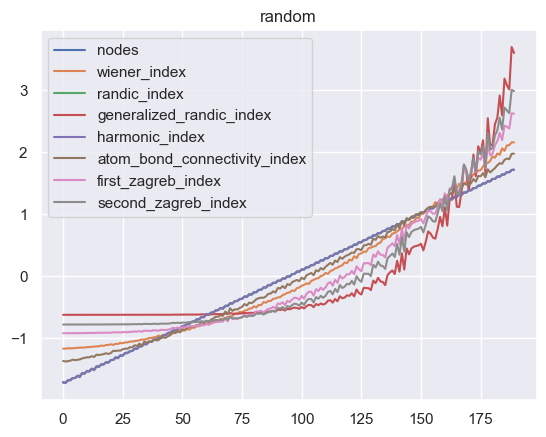

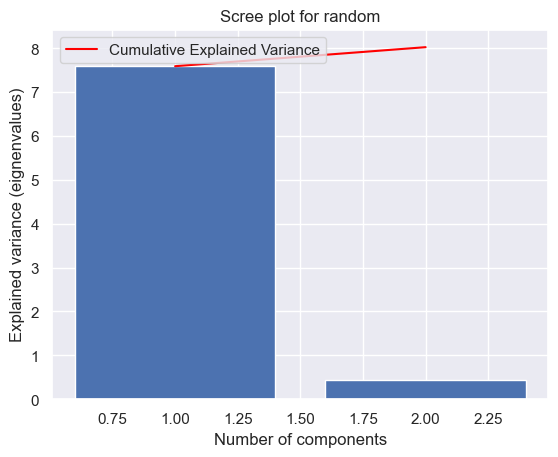

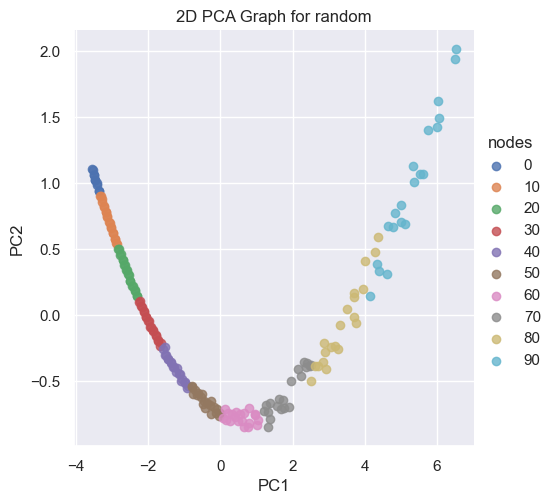

------------ PCA random 2 components ------------
         nodes  wiener_index  randic_index  generalized_randic_index  harmonic_index  atom_bond_connectivity_index  first_zagreb_index  second_zagreb_index
PC-1  0.354268      0.363163      0.354275                  0.330303        0.354285                      0.361494            0.359133             0.350462
PC-2 -0.344633     -0.018225     -0.344600                  0.628918       -0.344467                     -0.168031            0.230629             0.408078

topological_indices_all_graphs key: smallworld, shape: 190


c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

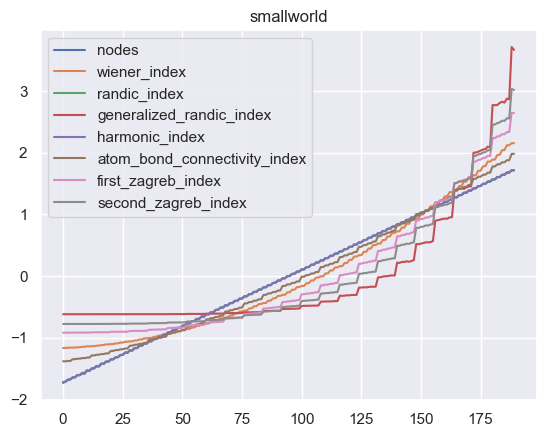

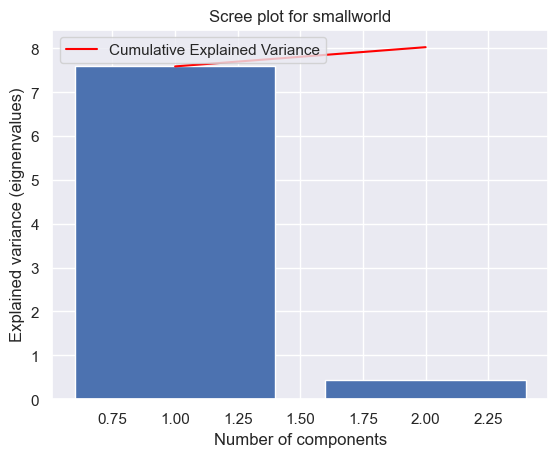

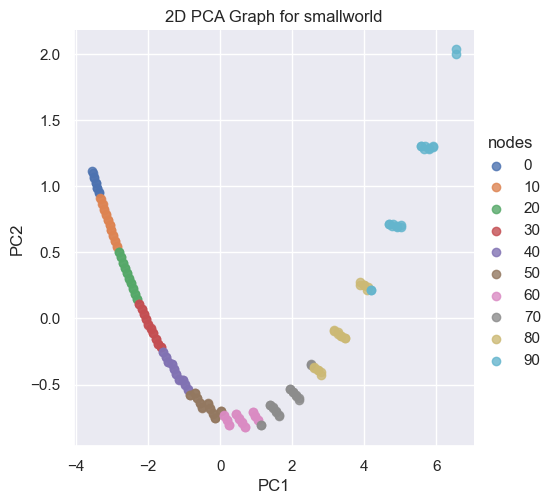

------------ PCA smallworld 2 components ------------
         nodes  wiener_index  randic_index  generalized_randic_index  harmonic_index  atom_bond_connectivity_index  first_zagreb_index  second_zagreb_index
PC-1  0.354314      0.363301      0.354296                  0.329972        0.354279                      0.361580            0.359196             0.350415
PC-2 -0.343886     -0.018834     -0.344180                  0.629406       -0.344421                     -0.168412            0.230563             0.408201

topological_indices_all_graphs key: scalefree, shape: 98


<Figure size 640x480 with 0 Axes>

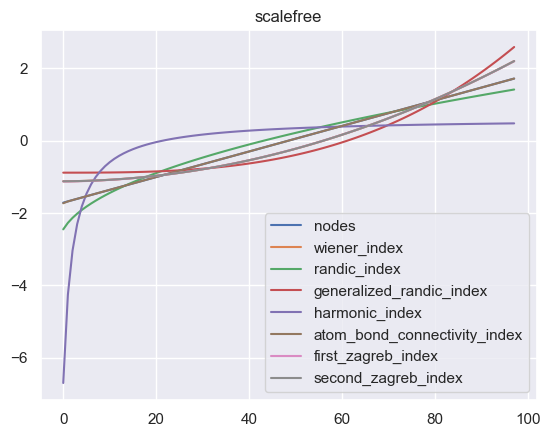

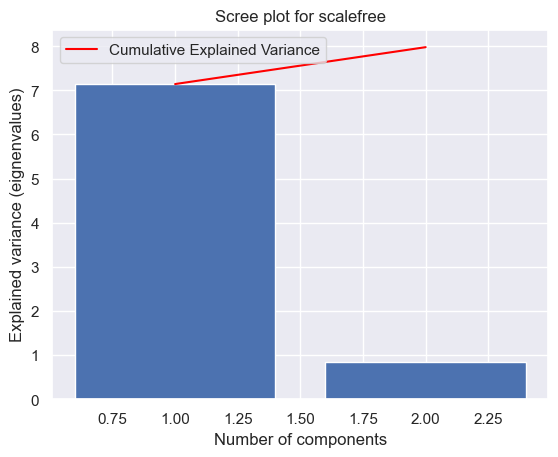

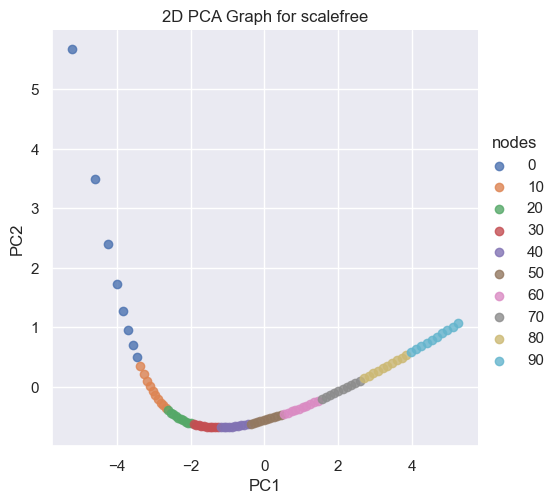

------------ PCA scalefree 2 components ------------
         nodes  wiener_index  randic_index  generalized_randic_index  harmonic_index  atom_bond_connectivity_index  first_zagreb_index  second_zagreb_index
PC-1  0.373670      0.370482      0.362733                  0.357502        0.222426                      0.373684            0.370623             0.370482
PC-2 -0.032919      0.182832     -0.231372                  0.282766       -0.874474                     -0.034349            0.180795             0.182832

topological_indices_all_graphs key: complete, shape: 98


c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


<Figure size 640x480 with 0 Axes>

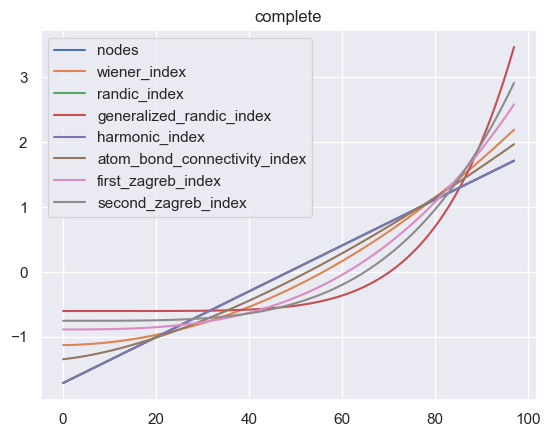

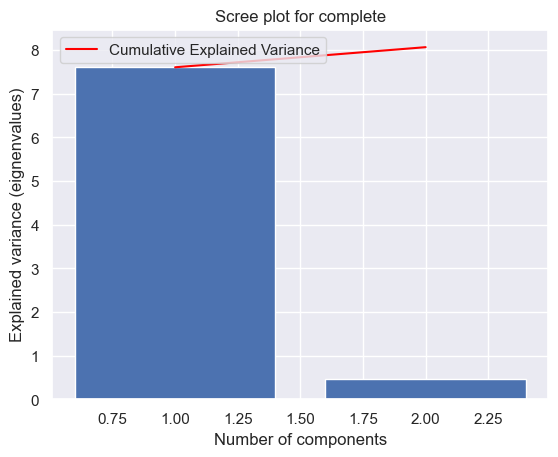

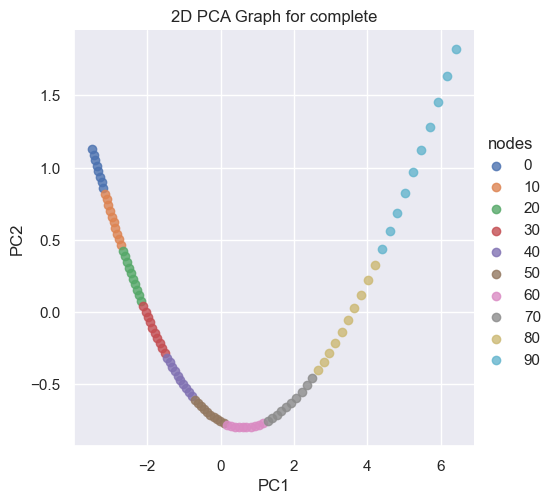

------------ PCA complete 2 components ------------
         nodes  wiener_index  randic_index  generalized_randic_index  harmonic_index  atom_bond_connectivity_index  first_zagreb_index  second_zagreb_index
PC-1  0.354121      0.363859      0.354121                  0.329652        0.354121                      0.362005            0.359232             0.350194
PC-2 -0.347770     -0.009517     -0.347770                  0.621230       -0.347770                     -0.166214            0.236371             0.409455

topological_indices_all_graphs key: line, shape: 98


<Figure size 640x480 with 0 Axes>

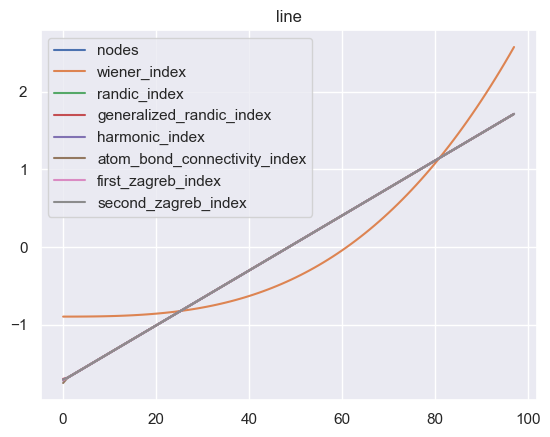

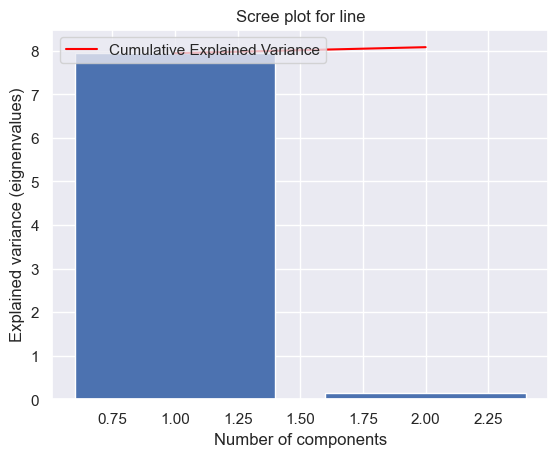

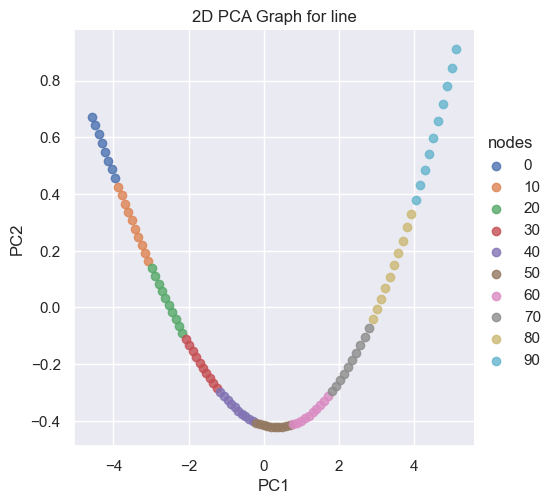

------------ PCA line 2 components ------------
         nodes  wiener_index  randic_index  generalized_randic_index  harmonic_index  atom_bond_connectivity_index  first_zagreb_index  second_zagreb_index
PC-1  0.356239      0.334154      0.356240                  0.356244        0.356242                      0.356226            0.356239             0.356241
PC-2 -0.126375      0.942516     -0.126086                 -0.125426       -0.125813                     -0.128059           -0.126375            -0.125953

topological_indices_all_graphs key: tree, shape: 190


<Figure size 640x480 with 0 Axes>

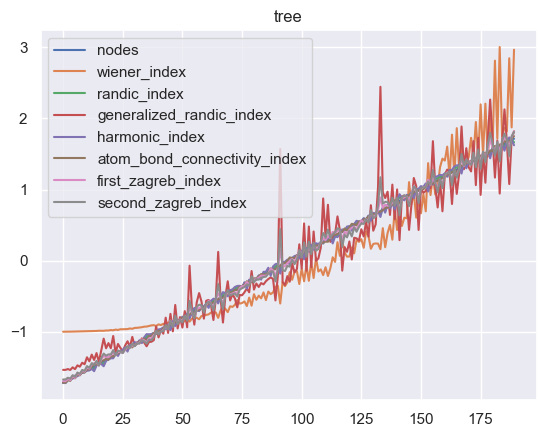

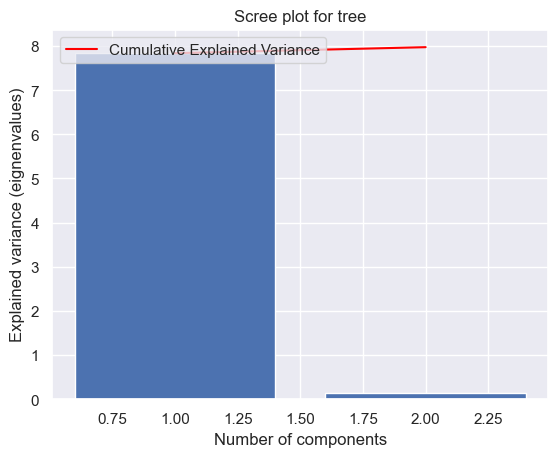

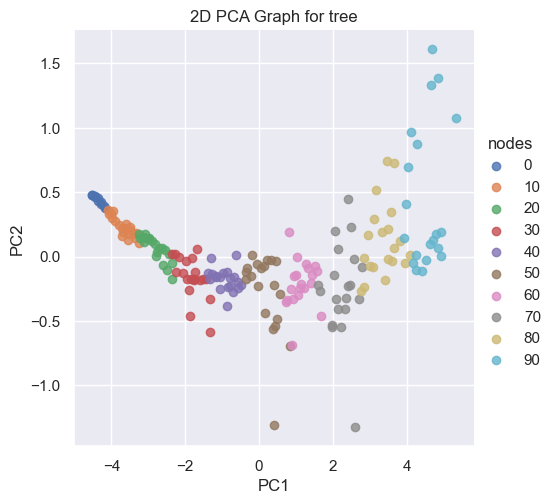

------------ PCA tree 2 components ------------
         nodes  wiener_index  randic_index  generalized_randic_index  harmonic_index  atom_bond_connectivity_index  first_zagreb_index  second_zagreb_index
PC-1  0.357406      0.337707      0.357110                  0.346417        0.356745                      0.357438            0.357767             0.357291
PC-2 -0.038051      0.869261     -0.031475                 -0.451019       -0.024624                     -0.030356           -0.089419            -0.170306



In [54]:
# now we perform the PCA on the dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import preprocessing
from tqdm.notebook import tqdm

pd.set_option('display.width', 1000)
sns.set()


def topo_numpy_array(topological_indices_subset): 
    topo_dataset = []
    for (i, graph_topo) in enumerate(topological_indices_subset):
        graph_ti_dict = topological_indices_subset[graph_topo]
        graph_ti_float_values = np.array(list(graph_ti_dict.values()), dtype=float)

        if np.any(np.isinf(graph_ti_float_values)):
            print(f"inf in graph {graph_topo}")
            continue
        
        topo_dataset.append(np.array(graph_ti_float_values))

    return topo_dataset


def plot_pd_frame(dataset, title):
    ''' Plot a pandas dataframe.'''
    plt.figure()
    dataset.plot()
    plt.legend(loc='best')
    plt.title(title)
    plt.show()


def print_scree_plot(key, data_scaled):
    pca = PCA(n_components=2)
    # Fit and transform data
    reduced_features = pca.fit_transform(data_scaled)
    
    # Bar plot of explained_variance
    plt.bar(
        range(1,len(pca.explained_variance_)+1),
        pca.explained_variance_
        )
    
    plt.plot(
        range(1,len(pca.explained_variance_ )+1),
        np.cumsum(pca.explained_variance_),
        c='red',
        label='Cumulative Explained Variance')
    
    plt.legend(loc='upper left')
    plt.xlabel('Number of components')
    plt.ylabel('Explained variance (eignenvalues)')
    plt.title(f'Scree plot for {key}')
    
    plt.show()


def print_2d_pca_graph(key, data_scaled, data_unscaled):
    pca = PCA(n_components=2)
    pca_features = pca.fit_transform(data_scaled)

    pca_df = pd.DataFrame(
        data=pca_features, 
        columns=['PC1', 'PC2'])
    
    # group number of nodes 
    pca_df['nodes'] = data_unscaled['nodes']
    # group nodes by 10 steps
    pca_df['nodes'] = pca_df['nodes'].apply(lambda x: int(x/10)*10)

    pca_df.head()
    
    sns.lmplot(
        x='PC1', 
        y='PC2', 
        data=pca_df,
        hue='nodes', 
        fit_reg=False, 
        legend=True
        )
    
    plt.title(f'2D PCA Graph for {key}')
    plt.show()

def pca_dataset(pd_dataset, n_components):
    ''' Create a dictionary with the topological indices of all graphs in the dataset.'''
    pca = PCA(n_components=n_components)
    pca_res = pca.fit(pd_dataset)
    
    return pca_res


graph_ti_dict = next(iter(topological_indices_all_graphs["random"].values()))
feature_names = list(graph_ti_dict.keys())
for key in topological_indices_all_graphs.keys():
    print(f"topological_indices_all_graphs key: {key}, shape: {len(topological_indices_all_graphs[key])}")
    numpy_arr = topo_numpy_array(topological_indices_all_graphs[key])
    # normalize data
    data_scaled = pd.DataFrame(preprocessing.scale(numpy_arr), columns = feature_names) 
    data_unscaled = pd.DataFrame(numpy_arr, columns = feature_names) 
    # plot scaled / normalized data
    plot_pd_frame(data_scaled, key)
    print_scree_plot(key, data_scaled)
    print_2d_pca_graph(key, data_scaled, data_unscaled)
    # PCA 2C
    pca_2c = pca_dataset(data_scaled, 2)
    # print results
    print(f"------------ PCA {key} 2 components ------------")
    print(pd.DataFrame(pca_2c.components_, columns=data_scaled.columns, index = ['PC-1','PC-2']))
    print("")


In [ ]:
# visualize the scaled features in 2D in an all in one scatterplot

from matplotlib.axes._axes import _log as matplotlib_axes_logger
import matplotlib.pyplot as plt
matplotlib_axes_logger.setLevel('ERROR')

graph_ti_dict = next(iter(topological_indices_all_graphs["random"].values()))
feature_names = list(graph_ti_dict.keys())
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(feature_names)))


for key in topological_indices_all_graphs.keys():
    numpy_arr = topo_numpy_array(topological_indices_all_graphs[key])

    data_unscaled = pd.DataFrame(numpy_arr, columns = feature_names) 
    # normalize data
    data_scaled = pd.DataFrame(preprocessing.scale(numpy_arr), columns = feature_names) 

    pca_2c = pca_dataset(data_scaled, 2)

    fig, ax = plt.subplots()
    for i, (feature, color) in enumerate(zip(feature_names, colors), 1):
        if feature == "nodes":
            continue

        ax.scatter(y = data_unscaled['nodes'], x = data_scaled[feature], label=feature, c=color)
        ax.set_ylabel('nodes')
        ax.set_xlabel('normalized feature value')
    

    plt.title(key)
    ax.legend()
    ax.grid(True)

    plt.show()


In [55]:
# now all we need to do is get the most influential feature for each class
graph_ti_dict = next(iter(topological_indices_all_graphs["random"].values()))
feature_names = list(graph_ti_dict.keys())

for key in topological_indices_all_graphs.keys():
    numpy_arr = topo_numpy_array(topological_indices_all_graphs[key])

    # normalize data
    data_scaled = pd.DataFrame(preprocessing.scale(numpy_arr), columns = feature_names) 

    pca_2c = pca_dataset(data_scaled, 2)

    n_pcs = pca_2c.components_.shape[0]
    most_important = [np.abs(pca_2c.components_[i]).argmax() for i in range(n_pcs)]
    most_important_names = [feature_names[most_important[i]] for i in range(n_pcs)]
    dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}
    df = pd.DataFrame(dic.items())

    print(f"------------ Most Important Features for PC(0) and PC(1) for cluster {key} ------------")
    print(df.head())

------------ Most Important Features for PC(0) and PC(1) for cluster random ------------
     0                         1
0  PC0              wiener_index
1  PC1  generalized_randic_index
------------ Most Important Features for PC(0) and PC(1) for cluster smallworld ------------
     0                         1
0  PC0              wiener_index
1  PC1  generalized_randic_index
------------ Most Important Features for PC(0) and PC(1) for cluster scalefree ------------
     0                             1
0  PC0  atom_bond_connectivity_index
1  PC1                harmonic_index
------------ Most Important Features for PC(0) and PC(1) for cluster complete ------------
     0                         1
0  PC0              wiener_index
1  PC1  generalized_randic_index
------------ Most Important Features for PC(0) and PC(1) for cluster line ------------
     0                         1
0  PC0  generalized_randic_index
1  PC1              wiener_index
------------ Most Important Features for 

c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
c:\Users\hoste\anaconda3\envs\pyg\lib\site-packages\sklearn\preprocessing\_data.py:240: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(
